In [1042]:
import numpy as np
import matplotlib.pyplot as plt

In [1043]:
nb_exp = 1
exp_prefix = "ALU_F3P_LENT_N_RUPT"
exp_numbers = [
    [f"_GR12-M_E{exp_number:03d}" for exp_number in [43]],
]
exp_filenames = [f"{exp_prefix}{exp_suffix}" for exp_suffix in exp_numbers[0]]

e0 = [2.1]
w0 = [20.1]
s0 = [e0[i] * w0[i] for i in range(nb_exp)]
L0 = [150]  # mm longueur totale de l'éprouvette
l0 = [110]  # longueur utile, donnée manquante pour l'essai

In [1044]:
# read infos of material
exp_filename = "ALU_ST_N_RUPT"

# Open the .res file for reading
with open(exp_filename + ".info", "r") as file:
    # Initialize an empty dictionary to store the item values
    item_values = {}

    # Read each line in the file
    for line in file:
        # Split the line into item and value
        item, value = line.strip().split(":")

        # Store the value in the dictionary with the item name as the key
        item_values[item.strip()] = float(value.strip())

# Create variables with the item names as the variable names and assign the corresponding values
for item, value in item_values.items():
    globals()[item] = value

# Print the variables
print(item_values)

E = item_values["E"]
Rp02 = item_values["Rp02"]
Km = item_values["Km"]

{'E': 73915.0, 'Rp02': 174.325, 'Rm': 296.488, 'Au': 0.157293, 'A': -1.0, 'strain rate': -1.0, 'Kv': 5530.18, 'Km': 8723.9, 'Kt': 15106.2}


In [1045]:
dat = [
    np.genfromtxt(
        exp + "/" + exp + ".raw", delimiter=",", skip_header=2, encoding="ISO-8859-1"
    )
    for exp in exp_filenames
]

In [1046]:
print(dat[0][:10, :])

[[ 0.0000e+00  0.0000e+00 -2.8760e-02]
 [ 2.0000e-03  0.0000e+00 -2.6270e-02]
 [ 4.0000e-03  0.0000e+00 -2.3900e-02]
 [ 1.0400e-01 -1.6490e-02 -1.9770e-02]
 [ 2.0400e-01 -3.9550e-02 -3.0440e-02]
 [ 3.0400e-01 -5.9780e-02 -4.3280e-02]
 [ 4.0400e-01 -7.9840e-02 -5.2240e-02]
 [ 5.0400e-01 -9.9960e-02  1.0000e-04]
 [ 6.0400e-01 -1.1991e-01 -2.9190e-02]
 [ 7.0400e-01 -1.3997e-01  6.9100e-03]]


In [1047]:
c_tps = 0  # s
c_dep_verin = 1  # mm
c_force = 2  # N
factor_force = -1  # raw values are <0
factor_dep_verin = -1  # raw values are <0

# extraction des données
tps = [experiment[:, c_tps] for experiment in dat]
dep_verin = [
    (experiment[:, c_dep_verin] - experiment[0, c_dep_verin]) * factor_dep_verin
    for experiment in dat
]
force = [(experiment[:, c_force] * factor_force) for experiment in dat]

In [1048]:
print(type(dep_verin[0]))

<class 'numpy.ndarray'>


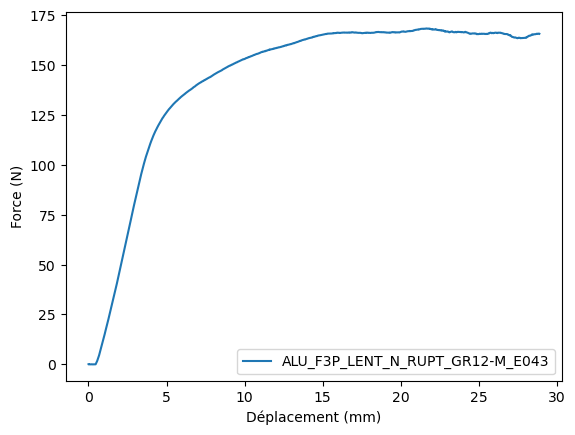

In [1049]:
# tracé des courbes force déplacement
plt.figure()
for i in range(nb_exp):
    plt.plot(dep_verin[i], force[i], label=exp_filenames[i])
    # plt.axis([0, 0.5, 0, 1])
    plt.xlabel("Déplacement (mm)")
    plt.ylabel("Force (N)")
    plt.legend()
plt.show()

In [1050]:
print(dep_verin[0])
print(force[0])

[-0.      -0.      -0.      ... 28.85995 28.87996 28.88234]
[2.8760000e-02 2.6270000e-02 2.3900000e-02 ... 1.6573912e+02 1.6566355e+02
 1.6564736e+02]


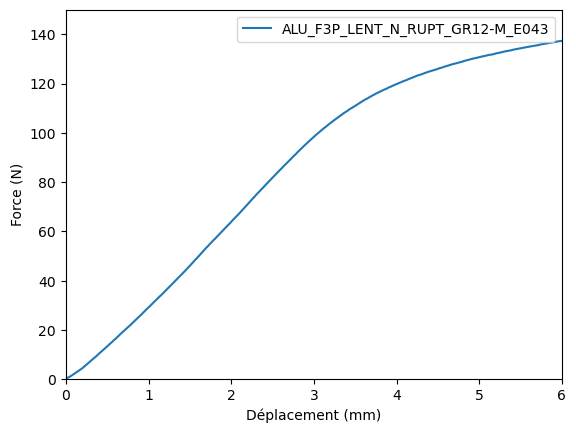

[array([0.000000e+00, 1.994000e-02, 4.006000e-02, ..., 2.837998e+01,
       2.839999e+01, 2.840237e+01])]
[array([  0.3627 ,   0.58252,   0.87867, ..., 165.73912, 165.66355,
       165.64736])]


In [1051]:
# cut beginning of data
delta_force = 1e-1
# find index of first time step where displacement is > delta_dep_verin
idxs = [np.where(force[i] > delta_force)[0][0] for i in range(nb_exp)]

# delete all data before this index
tps = [experiment[idx:] for experiment, idx in zip(tps, idxs)]
dep_verin = [
    (experiment[idx:] - experiment[idx]) for experiment, idx in zip(dep_verin, idxs)
]
force = [experiment[idx:] for experiment, idx in zip(force, idxs)]

plt.figure()
for i in range(nb_exp):
    plt.plot(dep_verin[i], force[i], label=exp_filenames[i])
    # plt.axis([0, 0.5, 0, 1])
    plt.xlabel("Déplacement (mm)")
    plt.ylabel("Force (N)")
    plt.legend()
    plt.axis([0, 6, 0, 150])
plt.show()

print(dep_verin)
print(force)

### Obtention de la rigidité de l'éprouvette en retranchant la rigidité machine


0.01929360148557535


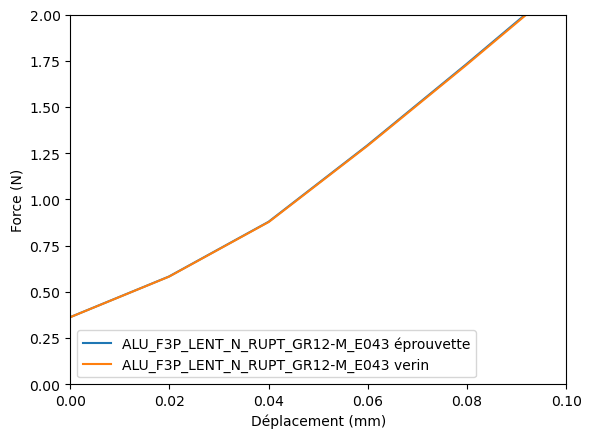

In [1052]:
dep_tens = [dep_verin[i] - force[i] / Km for i in range(nb_exp)]

errors = [np.abs(dep_tens[i] - dep_verin[i]) for i in range(nb_exp)]
print(np.max(errors))

plt.figure()
for i in range(nb_exp):
    plt.plot(dep_tens[i], force[i], label=exp_filenames[i] + " éprouvette")
    plt.plot(dep_verin[i], force[i], label=exp_filenames[i] + " verin")
    plt.xlabel("Déplacement (mm)")
    plt.ylabel("Force (N)")
    plt.legend()
    plt.axis([0, 0.1, 0, 2])
plt.show()

In [1053]:
# changement de variable pour utiliser la déformation éprouvette
dep_verin = dep_tens

-4.157544217609097e-05 2.9886519523378308


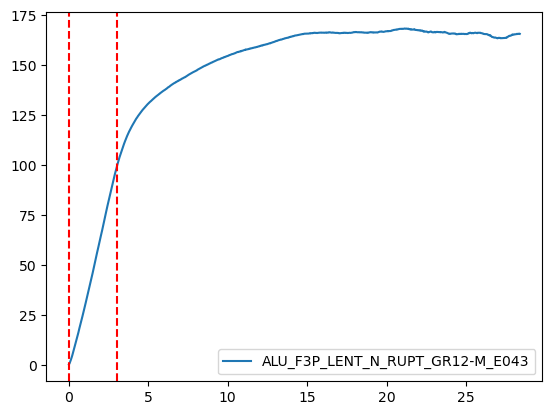

In [1054]:
# compute slope in elastic_zone
elastic_zone = [0.0, 3.0]
elastic_idx = [
    [
        np.argmin(np.abs(dep_verin[i] - elastic_zone[0])),
        np.argmin(np.abs(dep_verin[i] - elastic_zone[1])),
    ]
    for i in range(nb_exp)
]

elastic_dep_verins = [
    dep_verin[i][elastic_idx[i][0] : elastic_idx[i][1]] for i in range(nb_exp)
]
elastic_forces = [
    force[i][elastic_idx[i][0] : elastic_idx[i][1]] for i in range(nb_exp)
]

print(elastic_dep_verins[0][0], elastic_dep_verins[0][-1])

plt.plot(dep_verin[0], force[0], label=exp_filenames[0])
# add elastic zone
plt.axvline(x=elastic_zone[0], color="r", linestyle="--")
plt.axvline(x=elastic_zone[1], color="r", linestyle="--")
plt.legend()
plt.show()

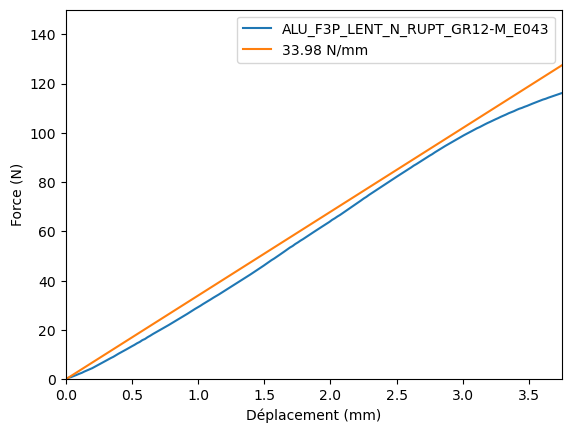

In [1055]:
# compute K
Kv = [np.polyfit(elastic_dep_verins[i], elastic_forces[i], 1)[0] for i in range(nb_exp)]
dep_verin_lin_force_reg = [Kv[i] * dep_verin[i] for i in range(nb_exp)]
# plot linear regression and data
plt.figure()
for i in range(nb_exp):
    plt.plot(dep_verin[i], force[i], label=exp_filenames[i])
    plt.plot(
        dep_verin[i],
        dep_verin_lin_force_reg[i],
        label=f"{Kv[i]:.2f} N/mm",
    )
    plt.xlabel("Déplacement (mm)")
    plt.ylabel("Force (N)")
    plt.axis([elastic_zone[0], elastic_zone[1] * 5 / 4, 0, 150])
    plt.legend()

# # shift dep_verin to 0
# dep_verin = [experiment - experiment[0] for experiment in dep_verin]

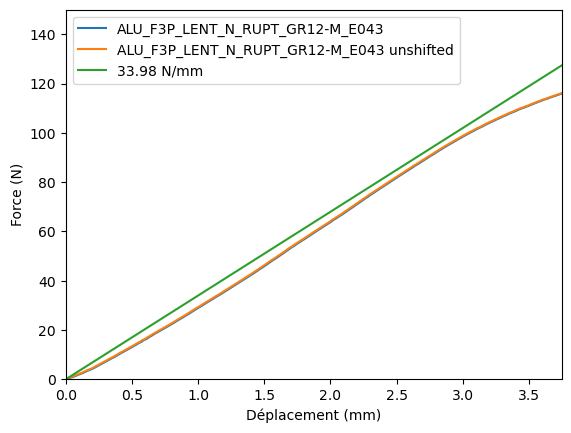

In [1056]:
# shift dep_verin to 0
f0s = [force[i][0] for i in range(nb_exp)]
shifted_dep_verins = [dep_verin[i] + f0s[i] / Kv[i] for i in range(nb_exp)]

# compute K * x
# delta_x = 200
# dep_verin_unif = [np.linspace(0, max(dep_verin[i]), delta_x) for i in range(nb_exp)]
dep_verin_unif = shifted_dep_verins
shifted_forces_lin_reg = [Kv[i] * dep_verin_unif[i] for i in range(nb_exp)]

# plot shifted data
plt.figure()
for i in range(nb_exp):
    plt.plot(shifted_dep_verins[i], force[i], label=exp_filenames[i])
    plt.plot(dep_verin[i], force[i], label=exp_filenames[i] + " unshifted")
    plt.plot(dep_verin_unif[i], shifted_forces_lin_reg[i], label=f"{Kv[i]:.2f} N/mm")
    plt.xlabel("Déplacement (mm)")
    plt.ylabel("Force (N)")
    plt.axis([elastic_zone[0], elastic_zone[1] * 5 / 4, 0, 150])
    plt.legend()
plt.show()

In [1057]:
# calcul contrainte déformation ingénieurs
eps = [dep_verin[i] / l0[i] for i in range(nb_exp)]  # unité (mm/mm)
sig = [force[i] / s0[i] for i in range(nb_exp)]  # unité (N/mm^2--> MPa)

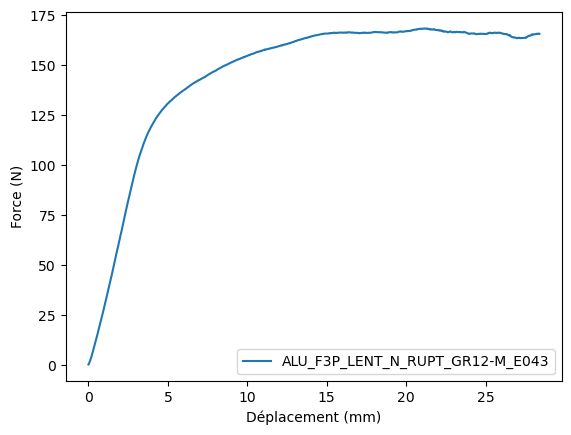

In [1058]:
# tracé des courbes force déplacement
plt.figure()
for i in range(nb_exp):
    plt.plot(dep_verin[i], force[i], label=exp_filenames[i])
    # plt.axis([0, 0.5, 0, 1])
    plt.xlabel("Déplacement (mm)")
    plt.ylabel("Force (N)")
    plt.legend()
plt.show()

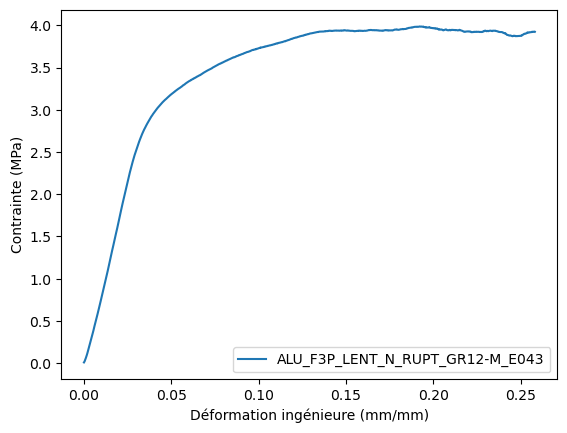

In [1059]:
# tracé des courbes contrainte déformation
plt.figure()
for i in range(nb_exp):
    plt.plot(eps[i], sig[i], label=exp_filenames[i])
    plt.xlabel("Déformation ingénieure (mm/mm)")
    plt.ylabel("Contrainte (MPa)")
    plt.legend()
plt.show()

### Comparaison avec les courbes simulées dans abaq


In [1061]:
# Lecture des données abaq

abaq_force_factor = 4.0

abaq_filenames = ["ForceDep-flexion3p-Alu"]

abaq_data = [{"dep_verin": [], "force": []}]

for i in range(nb_exp):
    # Open the file
    with open(abaq_filenames[i] + ".txt", "r") as file:
        # Skip the first three lines
        for _ in range(4):
            next(file)

        # Read the remaining lines
        for line in file:
            # Split each line into two columns
            line_split = line.strip().split()
            # delete empty strings
            line_split = list(filter(None, line_split))

            if len(line_split) == 0:  # skip empty lines
                continue
            else:
                # take absolute value of force and displacement
                line_values = [abs(float(val)) for val in line_split]
                # multiply force by factor 4 (symetries)
                line_values[1] *= abaq_force_factor
                abaq_data[i]["dep_verin"].append(float(line_values[0]))
                abaq_data[i]["force"].append(float(line_values[1]))

In [1062]:
# abaq_data[0]

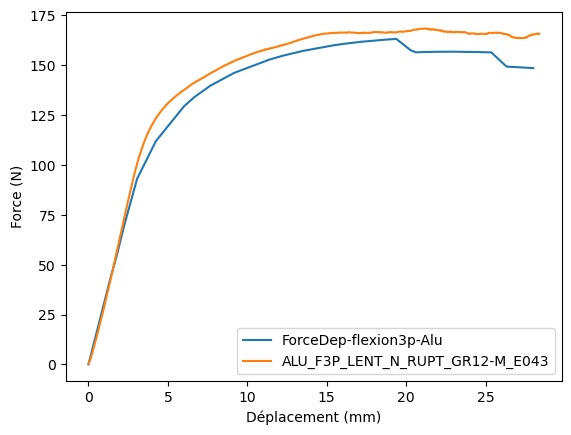

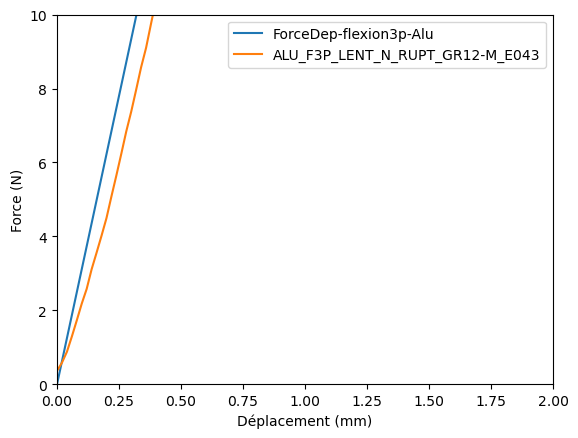

In [1063]:
# tracé des courbes force déplacement
plt.figure()
for i in range(nb_exp):
    plt.plot(abaq_data[i]["dep_verin"], abaq_data[i]["force"], label=abaq_filenames[i])
    plt.plot(dep_verin[i], force[i], label=exp_filenames[i])
    plt.xlabel("Déplacement (mm)")
    plt.ylabel("Force (N)")
    plt.legend(loc="best")
plt.show()

# tracé des courbes force déplacement
plt.figure()
for i in range(nb_exp):
    plt.plot(abaq_data[i]["dep_verin"], abaq_data[i]["force"], label=abaq_filenames[i])
    plt.plot(dep_verin[i], force[i], label=exp_filenames[i])
    plt.xlabel("Déplacement (mm)")
    plt.ylabel("Force (N)")
    plt.legend(loc="best")
    plt.axis([0, 2, 0, 10])
plt.show()

### Calcul de la rigidité par la théorie des poutres


In [1064]:
Rtot = [8 / 3 * E * w0[i] * e0[i] ** 3 / l0[i] ** 3 for i in range(nb_exp)]

shifted_forces_theo = [Rtot[i] * dep_verin_unif[i] for i in range(nb_exp)]

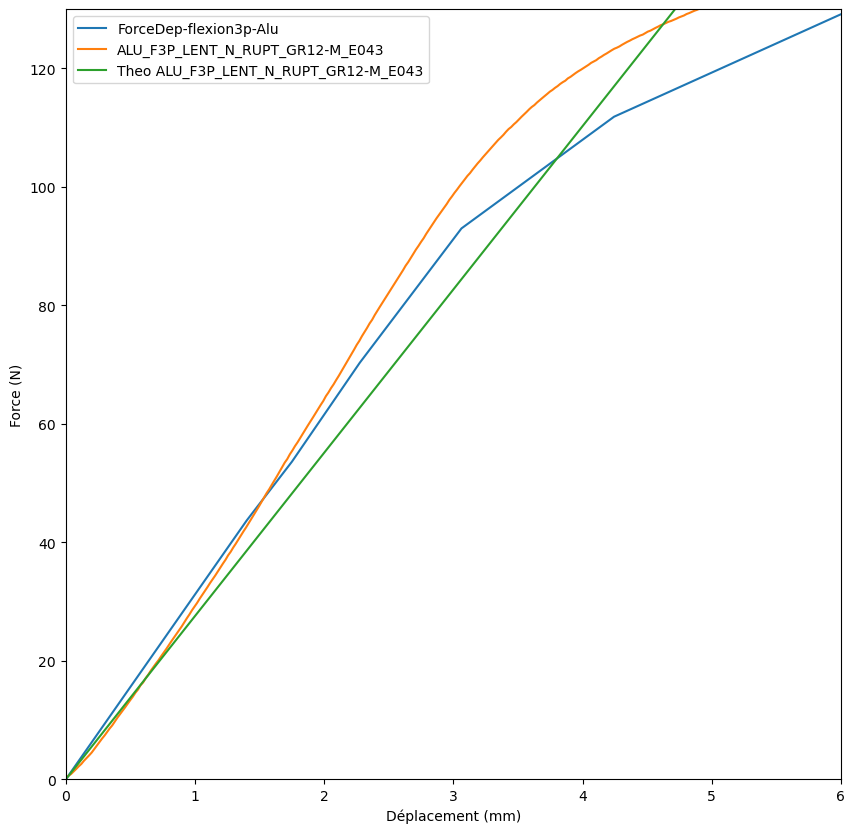

In [1065]:
# tracé des courbes force déplacement
plt.figure(figsize=(10, 10))
for i in range(nb_exp):
    plt.plot(abaq_data[i]["dep_verin"], abaq_data[i]["force"], label=abaq_filenames[i])
    plt.plot(dep_verin[i], force[i], label=exp_filenames[i])
    plt.plot(
        dep_verin_unif[i], shifted_forces_theo[i], label=f"Theo {exp_filenames[i]}"
    )
    plt.xlabel("Déplacement (mm)")
    plt.ylabel("Force (N)")
    plt.legend(loc="best")
    plt.axis([0, 6, 0, 130])
plt.show()